In [1]:
from pydriller import Repository
import datetime

repo = 'lucene'
url = "C:\\Users\\Ashwitha Kassetty\\Documents\\SE_Data\\lucene\\.git"

commits = list(Repository(url).traverse_commits())
no_of_commits = []
total_commits = []
i=0
delta = datetime.timedelta(weeks=4)
while i < len(commits):
#     print(commits[i].author_date)
    date1 = commits[i].author_date
    j = i+1
    while j<len(commits) and commits[j].author_date -date1 <= delta:
        j+=1
    if j>=len(commits):
        break
    date2 = commits[j].author_date
    date3 = commits[j-1].author_date
    total_commits.append(j)
    i = j+1
total_commits.append(j) 

no_of_commits = [0]+[total_commits[0]] +[total_commits[i] - total_commits[i-1] for i in range(1, len(total_commits))]
total_commits = [0] + total_commits

In [2]:
print(total_commits[-1])

35494


In [3]:
from pydriller import Repository
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime


steps = []
congruences = []
commits = list(Repository(url).traverse_commits())
delta = datetime.timedelta(weeks=4)
# step = int(len(commits)/100)
# for k in range(0,len(commits), step):
for k in range(0, len(no_of_commits)-1):
    i = 0
    file_to_users = {}  ## for each file how many users commited
    file_to_id = {}     ##
    tmp_commits = commits[total_commits[k]:total_commits[k+1]]
    print("reached till commits: ",total_commits[k])
#     if(len(tmp_commits)<step):
#         break
    for commit in tmp_commits:
        #print('The commit  has been modified by {} on {} and files changed are {}\n'.
              #format(commit.author.email,commit.committer_date,[x.filename for x in commit.modified_files]))
        
        
        for x in commit.modified_files:
            if x.filename not in file_to_users:
                file_to_users[x.filename] = set()
                file_to_users[x.filename].add(str(commit.author.email))
                if x.filename not in file_to_id:
                    file_to_id[x.filename] = i
                    i = i+1
            else:
                file_to_users[x.filename].add(str(commit.author.email))
                if x.filename not in file_to_id:
                    file_to_id[x.filename] = i
                    i = i+1


    ### Identifing unique users for each files
    unique_users_dict = {}
    unique_users = set()
    i = 0
    for x in file_to_users.keys():
        file_to_users[x] = list(file_to_users[x])
        for user in file_to_users[x]:
            if user not in unique_users_dict:
                unique_users_dict[user] = i
                i=i+1
            unique_users.add(user)


    ### Calculation of Actual Coordination - fct (file changed together)
    ## Assumption - 1 files - n developers have changed it. So they would have communicated at one point. 

    list_unique_users = unique_users
    AC = [[0]*len(list_unique_users) for x in range(0,len(list_unique_users))]

    for key in file_to_users.keys():
        users = file_to_users[key]
        for i in range(0, len(users)):
            for j in range(i+1,len(users)):
                AC[unique_users_dict[users[i]]][unique_users_dict[users[j]]] = 1
                AC[unique_users_dict[users[j]]][unique_users_dict[users[i]]] = 1


    ### Calculation of Coordination needs matrix: TA * TD * TAT

    CR = []
    TA = [[0]*len(file_to_users.keys()) for x in range(0,len(list_unique_users))]
    TD = [[0]*len(file_to_users.keys()) for x in range(0,len(file_to_users.keys()))]   
    ### TD - m * m; m = number of files TD[i][j] = ith file and jth file are dependent on each other.
    ### if in commit they are changed togteher they are dependent. So we have assumption of undirected graph.

    for key in file_to_users.keys():
        list_of_users = file_to_users[key]
        for x in list_of_users:
            TA[unique_users_dict[x]][file_to_id[key]] = 1 

    for commit in tmp_commits:
        modified_files_in_commit = commit.modified_files
        for i in range(0, len(modified_files_in_commit)):
            for j in range(i, len(modified_files_in_commit)):
                TD[file_to_id[modified_files_in_commit[i].filename]][file_to_id[modified_files_in_commit[j].filename]] = 1
                TD[file_to_id[modified_files_in_commit[j].filename]][file_to_id[modified_files_in_commit[i].filename]] = 1


    TA = pd.DataFrame(TA)
    TD = pd.DataFrame(TD)
    AC = pd.DataFrame(AC)
    
    CR = TA @ TD @ TA.T  
    
    CR_normalised = CR / CR.max(axis=0)
    diff =  (CR_normalised - AC)
    
    CR_count=0
    for i in range(0, len(CR_normalised)):
        for j in range(len(CR_normalised[0])):
            if CR_normalised[i][j] > 0:
                CR_count+=1
#     print("step:", step)
    print('CR_count:', CR_count)
    
    diff_count=0
    for i in range(0, len(diff)):
        for j in range(len(diff[0])):
            if diff[i][j] > 0:
                diff_count+=1
    print('diff_count:', diff_count)
    if CR_count!=0:
        congruence = diff_count / CR_count
        print('congruence:',congruence)
        congruences.append(congruence)
    else:
        congruences.append(0)

reached till commits:  0
CR_count: 14
diff_count: 6
congruence: 0.42857142857142855
reached till commits:  34
CR_count: 10
diff_count: 4
congruence: 0.4
reached till commits:  54
CR_count: 3
diff_count: 3
congruence: 1.0
reached till commits:  59
CR_count: 9
diff_count: 5
congruence: 0.5555555555555556
reached till commits:  72
CR_count: 33
diff_count: 13
congruence: 0.3939393939393939
reached till commits:  118
CR_count: 8
diff_count: 4
congruence: 0.5
reached till commits:  142
CR_count: 5
diff_count: 3
congruence: 0.6
reached till commits:  156
CR_count: 10
diff_count: 4
congruence: 0.4
reached till commits:  186
CR_count: 12
diff_count: 4
congruence: 0.3333333333333333
reached till commits:  220
CR_count: 5
diff_count: 3
congruence: 0.6
reached till commits:  257
CR_count: 2
diff_count: 2
congruence: 1.0
reached till commits:  262
CR_count: 4
diff_count: 2
congruence: 0.5
reached till commits:  286
CR_count: 4
diff_count: 2
congruence: 0.5
reached till commits:  317
CR_count: 5
dif

CR_count: 81
diff_count: 31
congruence: 0.38271604938271603
reached till commits:  7620
CR_count: 3840
diff_count: 404
congruence: 0.10520833333333333
reached till commits:  24352
CR_count: 987
diff_count: 205
congruence: 0.2077001013171226
reached till commits:  24647
CR_count: 790
diff_count: 126
congruence: 0.15949367088607594
reached till commits:  24908
CR_count: 855
diff_count: 171
congruence: 0.2
reached till commits:  25186
CR_count: 768
diff_count: 156
congruence: 0.203125
reached till commits:  25377
CR_count: 729
diff_count: 121
congruence: 0.16598079561042525
reached till commits:  25534
CR_count: 388
diff_count: 122
congruence: 0.31443298969072164
reached till commits:  25647
CR_count: 363
diff_count: 79
congruence: 0.21763085399449036
reached till commits:  25772
CR_count: 478
diff_count: 196
congruence: 0.4100418410041841
reached till commits:  25929
CR_count: 485
diff_count: 61
congruence: 0.12577319587628866
reached till commits:  26125
CR_count: 432
diff_count: 146
co

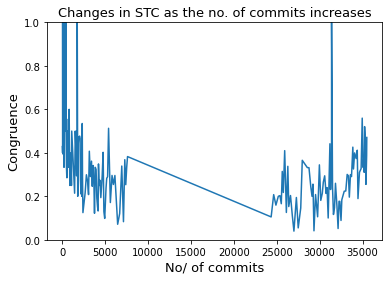

In [4]:

plt.plot(total_commits[1:], congruences)
plt.title("Changes in STC as the no. of commits increases", fontsize = 13)
plt.xlabel("No/ of commits", fontsize=13)
plt.ylabel("Congruence", fontsize = 13)
plt.ylim(0,1)
plt.savefig('images/'+repo+'.png')
plt.show()

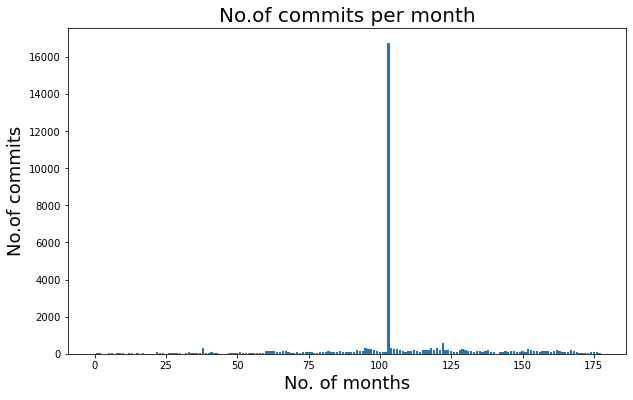

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177]
[0, 34, 20, 5, 13, 46, 24, 14, 30, 34, 37, 5, 24, 31, 12, 35, 9, 22, 14, 12, 3, 9, 74, 39, 28, 13, 20, 36, 52, 38, 45, 9, 29, 81, 67, 61, 63, 32, 335, 44, 30, 105, 54, 36, 13, 13, 11, 55, 51, 23, 57, 99, 49, 43, 62, 43,

In [5]:
import matplotlib.pyplot as plt
x_axis1 = [0]
for i in range(1, len(no_of_commits)):
    x_axis1.append(x_axis1[i-1] + 1)


plt.figure(figsize =(10,6))
plt.bar(x_axis1, no_of_commits)
plt.xlabel("No. of months", fontsize =18)
plt.ylabel("No.of commits", fontsize =18)
plt.title("No.of commits per month" , fontsize =20)
plt.savefig('images/'+repo+'1.png')
plt.show()

print(x_axis1)
print(no_of_commits)

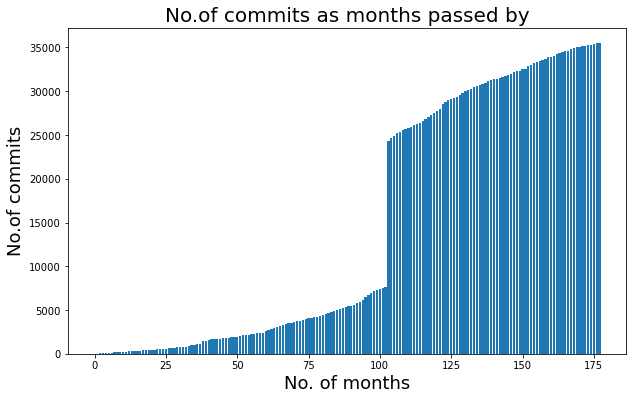

In [6]:
plt.figure(figsize =(10,6))
plt.bar(x_axis1, total_commits)
plt.xlabel("No. of months", fontsize =18)
plt.ylabel("No.of commits", fontsize =18)
plt.title("No.of commits as months passed by", fontsize = 20)
plt.savefig('images/'+repo+'2.png')
plt.show()

In [7]:
noofmonths = x_axis1[1:]
noofcommits = no_of_commits[1:]
print(len(noofcommits))
name = 'csv files/'+repo + '.csv'
dict = {'no_of_months': noofmonths, 'no_of_commits': noofcommits, 'congruences': congruences}  
       
df = pd.DataFrame(dict) 
    
# saving the dataframe 
df.to_csv(name) 

177
